In [21]:
import pandas as pd

# 1.) Clean the Apple Data to get a quarterly series of EPS.

In [22]:
y = pd.read_csv("AAPL_quarterly_financials.csv")

In [23]:
y.index = y.name

In [24]:
y = pd.DataFrame(y.loc["BasicEPS", :]).iloc[2:,:]

In [25]:
y.index = pd.to_datetime(y.index)

In [26]:
# CHECK IF NAS ARE NO DIVIDEND PERIOD
y = y.sort_index().fillna(0.)

# 2.) Come up with 6 search terms you think could nowcast earnings. (Different than the ones I used) Add in 3 terms that that you think will not Nowcast earnings. Pull in the gtrends data

In [27]:
pip install pytrends


Note: you may need to restart the kernel to use updated packages.


In [28]:
from pytrends.request import TrendReq

In [29]:
# Create pytrends object
pytrends = TrendReq(hl='en-US', tz=360)

# Set up the keywords and the timeframe
keywords = ["Apple", "Samsung", "Iphone", "Taylor Swift", "NASDAQ", "UCLA"]  
start_date = '2004-01-01'
end_date = '2024-01-01'

# Create an empty DataFrame to store the results
df = pd.DataFrame()

# Iterate through keywords and fetch data
for keyword in keywords:
    pytrends.build_payload([keyword], cat=0, timeframe=f'{start_date} {end_date}', geo='', gprop='')
    interest_over_time_df = pytrends.interest_over_time()
    df[keyword] = interest_over_time_df[keyword]

In [30]:
df = df.resample("Q").mean()

In [31]:
df = df.fillna(0)
X = df 
X = X[X.index.isin(y.index)]
y = y[y.index.isin(X.index)]

In [32]:
# ALIGN DATA
temp = pd.concat([y, X],axis = 1).dropna()
y = temp[["BasicEPS"]].copy()
X = temp.iloc[:,1:].copy()

# 3.) Normalize all the X data

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4.) Run a Lasso with lambda of .5. Plot a bar chart.

In [35]:
from sklearn.linear_model import Lasso

In [36]:
l = Lasso(alpha = 0.05)
l.fit(X_scaled, y)
Coefficients = l.coef_
Coefficients

array([ 0.21527763,  0.        ,  0.        ,  0.        ,  0.22954048,
       -0.07444765])

In [37]:
import matplotlib.pyplot as plt

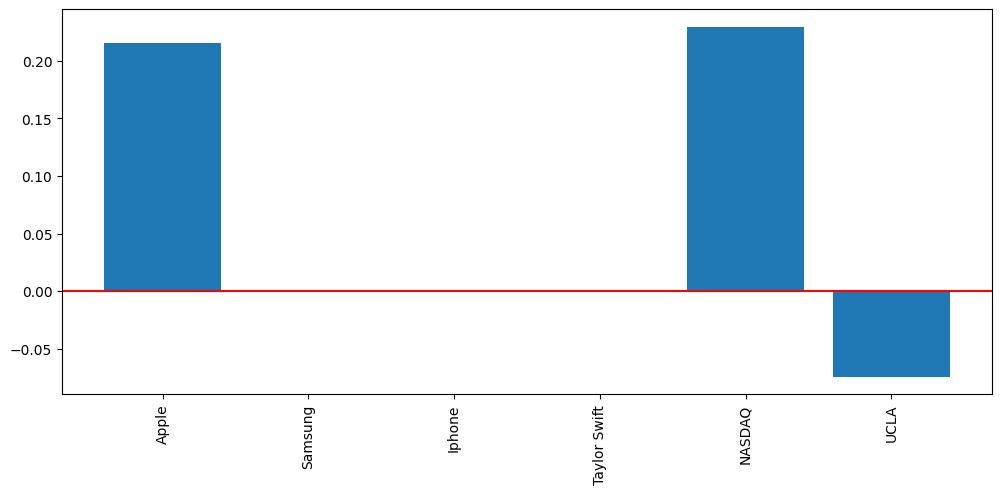

In [38]:
plt.figure(figsize = (12,5))
plt.bar(range(len(Coefficients)), Coefficients)
plt.xticks(range(len(Coefficients)), X.columns, rotation = 'vertical')
plt.axhline(0, color = "red")
plt.show()

# 5.) Do these coefficient magnitudes make sense?

The first coefficient with the term search of "Apple" with respect to our target varibale, "BasicEPS", shows that there is a positve direction in their relationship but the effect between the two isn't too strong. This coefficient doesn't really make sense because it would make sense to be more seraches for the word "Apple" on Google, when one is concerned about the EPS of Apple Inc. However, compared to other coefficients, the magnitude and direction of the coefficients still validate the expected relationship between the two. 

The second coefficient for the feature "Samsung" with respect to Apple EPS, shows that there is no effect. The alpha penalizes the feature so much, that it shrinks the coefficients to zero. However, this would also not make sense, since one concerned with EPS of Apple would be concerned with the developemnt in Samsung, to udnerstand the potential profits. 

The thrid coefficient for the google term search "Iphone" with respect to Apple EPS, shows that there exists no relationship, hpwever, this is contradictory tot he expected relationship. 

The fourth coefficients for the term search "taylor Swift" for the Apple EPS, the Lasso fit shrinks the coefficients to 0 but this relationship is expected.

The fifth coefficient for the term search "NASDAQ" with respect to Apple EPS, Lasso shows a positive direction, however, one conncerned with Apple EPS would want to analyse the NASDAQ index performance to guage the potential profits from investing. Therefore, this coefficient doesn't make sense and is not in congizance witht he expected relationship, the ,magnitude of the coefficient should be large enough.

The sixth coeffieicnt for the term search "UCLA" for Apple EPS, the Lasso shows a negative relationship, which expected. The coefficient here makes sense. however, the maginutde could have been much smaller, as there exists practically no expected relationship between the two. 